### In this notebook I want to do a similar analysis to that of [Trinquier, Weigt](https://pubmed.ncbi.nlm.nih.gov/34608136/). We hence want to plot the projection onto the first two PCA components of the true MSAs for samples generated respectively from the ESM model and out Potts Decoder.

In [1]:
import torch
import numpy as np
import scipy
import os
import sys
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
from Bio import SeqIO


git_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/InverseFolding'
esm_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/'
sys.path.insert(1, os.path.join(git_folder, 'model'))
sys.path.insert(1, os.path.join(git_folder, 'util'))

sys.path.insert(1, esm_folder)
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained

## I import this to try to get deeper on the sampling perplexity
from esm.inverse_folding.features import DihedralFeatures
from esm.inverse_folding.gvp_encoder import GVPEncoder
from esm.inverse_folding.gvp_utils import unflatten_graph
from esm.inverse_folding.gvp_transformer_encoder import GVPTransformerEncoder
from esm.inverse_folding.transformer_decoder import TransformerDecoder
from esm.inverse_folding.util import rotate, CoordBatchConverter 


#### Code for model with PLL ########
#from potts_decoder import PottsDecoder
#### Code for model with NCE ##########
from potts_decoder import PottsDecoder
from ioutils import read_fasta, read_encodings

from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.nn.functional import one_hot

from collections import defaultdict

import matplotlib.pyplot as plt



In [24]:
V = np.random.rand(3,2)
n,k = 3,2

In [29]:
V1  = np.dot(np.transpose(V), V)

V2 = np.zeros((k,k))
for j in range(n):
    V2 += np.dot(np.transpose(V[j:j+1, :]), V[j:j+1,:])

In [30]:
V2

array([[1.20710937, 0.79994964],
       [0.79994964, 0.83661032]])

In [31]:
V1

array([[1.20710937, 0.79994964],
       [0.79994964, 0.83661032]])

In [2]:
def load_structure(fpath, chain=None):
    """
    Args:
        fpath: filepath to either pdb or cif file
        chain: the chain id or list of chain ids to load
    Returns:
        biotite.structure.AtomArray
    """
    with open(fpath) as fin:
        pdbf = pdb.PDBFile.read(fin)
    structure = pdb.get_structure(pdbf, model=1)
    bbmask = filter_backbone(structure)
    structure = structure[bbmask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    return structure

def extract_coords_from_structure(structure: biotite.structure.AtomArray):
    """
    Args:
        structure: An instance of biotite AtomArray
    Returns:
        Tuple (coords, seq)
            - coords is an L x 3 x 3 array for N, CA, C coordinates
            - seq is the extracted sequence
    """
    coords = get_atom_coords_residuewise(["N", "CA", "C"], structure)
    residue_identities = get_residues(structure)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r) for r in residue_identities])
    return coords, seq

def get_atom_coords_residuewise(atoms: List[str], struct: biotite.structure.AtomArray):
    """
    Example for atoms argument: ["N", "CA", "C"]
    """
    def filterfn(s, axis=None):
        filters = np.stack([s.atom_name == name for name in atoms], axis=1)
        sum = filters.sum(0)
        if not np.all(sum <= np.ones(filters.shape[1])):
            raise RuntimeError("structure has multiple atoms with same name")
        index = filters.argmax(0)
        coords = s[index].coord
        coords[sum == 0] = float("nan")
        return coords

    return biotite.structure.apply_residue_wise(struct, struct, filterfn)

def get_loss_new(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
    msas_embedded = embedding(msas)

    # get npll
    npll = get_npll2(msas_embedded, param_embeddings, fields, N, q)
    padding_mask_inv = (~padding_mask)
    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    
    Q = torch.einsum('bkuia, buhia->bkhia', 
                param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)
    penalty = eta*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2) + torch.sum(fields**2))/B
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 

def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)
    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 
    #return loss_penalty

def get_loss_loader(decoder, loader, eta):

    decoder.eval()
    losses = 0
    iterator = 0
    with torch.no_grad():
        for inputs in loader:
            iterator+=1
            _, npll = get_loss_new(decoder, inputs, eta) 
            losses+=npll
    
    return losses/iterator

def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

In [4]:
device='cpu'
## This would work on windows
#bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'

bk_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Intermediate_Models"
fname_par = "model_20_01_2023_epoch_1000.0.pt"
checkpoint = torch.load(os.path.join(bk_dir, fname_par))

## Load parameters of the mode,
q=21
args = checkpoint['args_run']
n_layers = args['n_layers']
param_embed_dim = d_model = args['param_embed_dim']
input_encoding_dim = args['input_encoding_dim']
n_heads=args['n_heads']
n_param_heads=args['n_param_heads']
dropout=args['dropout']

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout);
decoder.to(device);

decoder.load_state_dict(checkpoint['model_state_dict']);
decoder.eval();   ##to generate data we need just the forward pass of the model!

In [6]:
mutational_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data'
msas_folder = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype'

protein_original_DMS = 'YAP1_HUMAN_1_b0.5.a2m.wildtype.fasta'
structure_name = 'YAP1_HUMAN_1_b0.5.a2m_unrelaxed_rank_1_model_5.pdb'

folder_fasta = os.path.join(mutational_dir, 'alignments')
native_path = os.path.join(folder_fasta, protein_original_DMS)
structure_folder = os.path.join(mutational_dir, 'alphafold_results_wildtype')
structure_path = os.path.join(structure_folder, structure_name)

num_seq = read_fasta(native_path, mutated_exp=True)
structure =  load_structure(structure_path)
coords, native_seq = extract_coords_from_structure(structure)
coords=torch.tensor(coords).to(device)

In [7]:
native_seq

'DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKA'

In [8]:
model, alphabet_esm = pretrained.esm_if1_gvp4_t16_142M_UR50()
model.eval();
model.to(device)
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet_esm, coords)

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/inverse_folding/util.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)


In [24]:
len(alphabet_esm.standard_toks)

27

In [8]:
rep.shape

torch.Size([36, 512])

In [266]:
q=21
N = rep.shape[0]
rep_padded = pad_sequence(rep.unsqueeze(0), batch_first=True, padding_value=0.0)
padding_mask = (num_seq[0].unsqueeze(1)[:, 0, :] == q)

#### Code for loss with PLL ###########
couplings, fields = decoder(rep_padded, padding_mask)
######## Code for loss with NCE ############
#param_embeddings, fields, logZ = decoder(rep_padded, padding_mask)
##param_embeddings = param_embeddings.flatten(start_dim=2, end_dim=3)

# outer to (B, N*q, N*q)
#couplings = torch.einsum('bpi, bpj -> bij', (param_embeddings, param_embeddings))

# create mask for couplings
#t = torch.ones(q, q)
#mask_couplings = (1 - torch.block_diag(*([t] * N)))#.to(couplings.device)
#mask_couplings.requires_grad = False

#couplings = couplings * mask_couplings
#couplings = couplings/np.sqrt(n_param_heads)

#fields = fields.flatten(start_dim=1, end_dim=2)
#####################################################################################################################################


#for i in range(36):
#    for j in range(36):
#        J_sup = couplings[i*q:(i+1)*q, j*q:(j+1)*q]
        
#couplings = couplings#*0.0001

In [267]:
## In this folder I will save the model in consideration, I won't save all of them due to memory
#auxiliary_model_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Auxiliary_Potts'
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
#auxiliary_model_dir = "."

B,N,_ = rep_padded.shape
with open(os.path.join(auxiliary_model_dir, "YAP1_HUMAN_couplings_fields.txt"), "w") as f:
    ## write J
    for i in range(N):
        for j in range(i+1, N):
            for aa1 in range(q):
                for aa2 in range(q):
                    J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                    line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                    f.write(line)
    
    ## write h
    for i in range(N):
        for aa in range(q):
            h_el = fields[0, i*q+aa1].detach().to('cpu').item()
            line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
            f.write(line)

In [268]:
auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
out_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
out_file = 'samples.txt'
samples_path = os.path.join(auxiliary_model_dir, "YAP1_HUMAN_couplings_fields.txt")
## The ! creates a terminal command, to pass variable you need to put square brackets
!(bmdca_sample -p {samples_path} -d {out_dir} -o {out_file})

initializing sampler... 0.00926583 sec

sampling model with mcmc... 0.116045 sec
updating mcmc stats with samples... 0.005158 sec
computing sequence energies and correlations... 0.0369924 sec
decreasing wait time to 600
writing final sequences... done


## Creating MSA for Potts 

In [45]:
alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

In [270]:
file='samples_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
file='samples_numerical.txt'
with open(os.path.join(out_dir,file), mode='r') as f:
    lines=f.readlines()

char_seq = [] ##36 is the lenght of YAP

for i in range(1, len(lines)):
    line = lines[i][0:-1].split(" ") ## I take out the end of file
    line_char = [aa_index_inv[int(idx)] for idx in line]
    char_seq.append(line_char)
    
## Now re-translate
for prot_idx in range(len(char_seq)):
    for aa in range(len(char_seq[prot_idx])):
        char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
        
msa_t = torch.tensor(char_seq, dtype=torch.long)
cov_potts = compute_covariance(msa_t, 21)

In [271]:
import re
fastapath = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype/MSAS_new/YAP1_HUMAN_1_b0.5.a2m.a3m"
with open(fastapath, mode="r") as f:
    lines = f.readlines()
lines = lines[1:]

msa_true = []
for line in range(len(lines)):
    if line%2 == 0:
        ## Take the end of sequence file
        seq_str = lines[line]#[0:-1]
        seq_num = []
        for char in seq_str:
            if char != '\n':
                seq_num.append(aa_index[char])
        if len(seq_num) == 36:
            msa_true.append(seq_num)
        else:
            print(failure)

msa_true = torch.tensor(msa_true)
cov_true = compute_covariance(msa_true[::,::], q=21)


In [272]:
msa_true.shape

torch.Size([14484, 36])

In [15]:
msa_t.shape

torch.Size([10000, 36])

In [16]:
from sklearn.decomposition import PCA
pca_mse = PCA(n_components=2)
pca_mse = pca_mse.fit(msa_true)

In [17]:
proj_true = pca_mse.transform(msa_true)

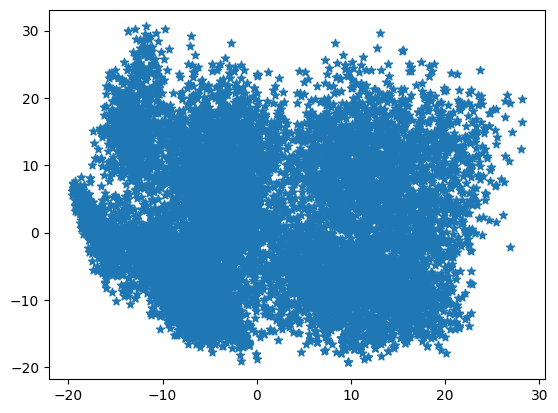

In [18]:
plt.scatter(proj_true[:, 0], proj_true[:, 1], marker="*")

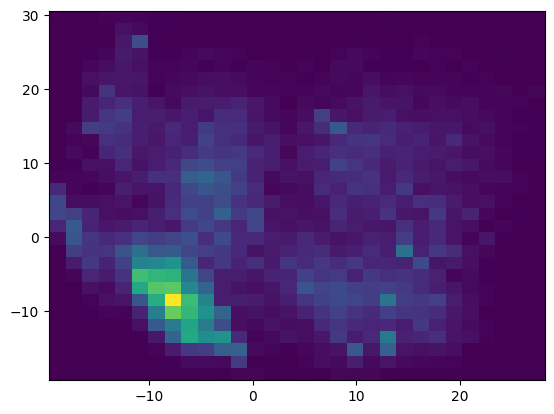

In [19]:
plt.hist2d(proj_true[:, 0], proj_true[:, 1],bins=30)
plt.show()

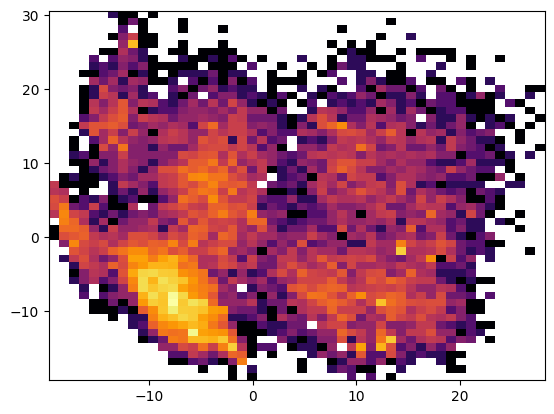

In [20]:
# Generate some test data
x = proj_true[:,0]
y = proj_true[:, 1]
from matplotlib import colors

fig, ax = plt.subplots(nrows=1, ncols=1)

#heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap="inferno")

ax.hist2d(x, y, bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

In [21]:
proj_potts = pca_mse.transform(msa_t)

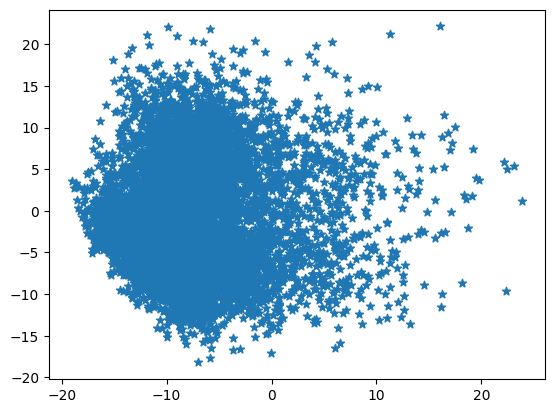

In [22]:
plt.scatter(proj_potts[:, 0], proj_potts[:, 1], marker="*")

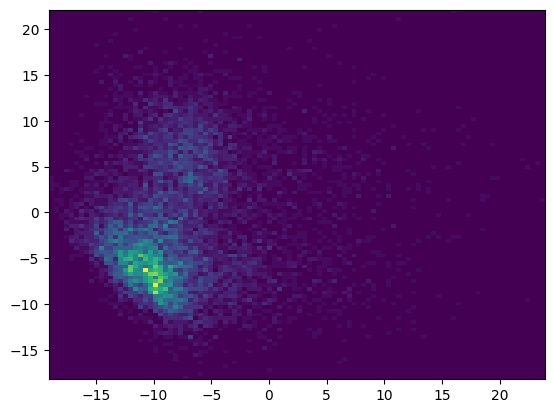

In [23]:
plt.hist2d(proj_potts[:, 0], proj_potts[:, 1],bins=100)
plt.show()

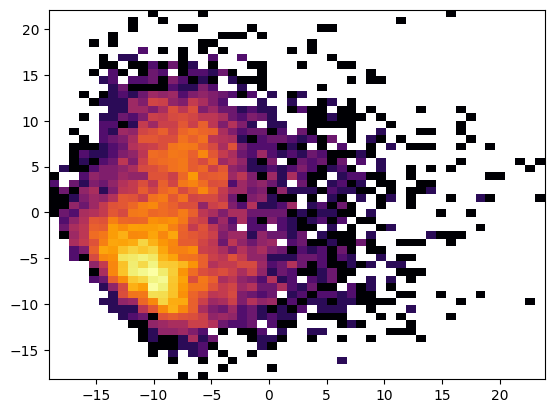

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1)

#heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap="inferno")
At this point the proof is exactly the same as before, hence we just state the proposition.

In [48]:
samples_esm = []
samples_str = []
for attempt in range(200):
    print(f"We are at sample {attempt} out of {1000}", end="\r")
    sample = model.sample(coords, temperature=1.0)
    samples_str.append(sample)
    seq_num = []
    for char in sample:
        seq_num.append(aa_index[char])
    samples_esm.append(seq_num)

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/inverse_folding/util.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)


In [47]:
samples_str

['YCDTDTHQPBTMYFGMDKT<eos>LNCSALRIGTCDTRVO',
 '<mask><mask>VPL<null_0>YWIW<cath>GDDCTGHDYCLFWDQNLVDYPYRNG',
 'VEFCHPWQRLLYDYZGTVTAHSUQQYHRFWWFNTMG',
 'CQKYKSVHRC<mask>AMEGMMRVTD-QWTRRGCQQIWYKF',
 'NKDFGLTFFFLKSFYDCGKAARQQFPZ<eos>A<null_1>KYE<af2>AM',
 'PRPPSYQN<cath>PESRXAEYNINFQYMEARYEHSDRCDK',
 'RAHPTMYBRVNHTFPQDLCTSDAIEQRM<null_1>YAVYRSW',
 'PTG.LYGQRR<eos>BXRSVHRFTN<cath>LCDMKPMDEWHENE',
 'YRANGNSTI<mask>FVLSKEFKRYHDT<unk>K<pad>AEHHTNCI<cath>F',
 'OUAERTKIHKGHLYVDMERTUDHCMSDDSTNBVEMS',
 'SMIPKTFEWSDENEHFWI<eos>IHMVDP<pad>F<pad>VUGPSRTR',
 'SRHALLKWAAOTPLLCYGAIWNVGLHACCSRSYPNT',
 'YEE<pad>P<unk>NECCVFGQTISRGWIQYPFCKDQXTNHQ<eos>I',
 'RVGPGEVRRELWIEGHKMTAADI<cath>DLR.TSPSNDGV',
 '<eos>SGYWLQYYSKAQTQCLLKMVSYAWYZ-AQYRYVWL',
 'SVEYEI<null_1>WDRVVCRNMEIW<unk>YNMYNETWYDH<mask>LSQT',
 'UFYRTAEEBDHSRLV<null_0>X<eos>DAKDM-HKCLXQNMIETQ',
 'ICY-PA-QQWNLNSN<null_0>IK<pad>PFLTTMRNAWTWPQGRQ',
 'NLDAHPGFNGCCKNGTRDVLHAETEHTVEAK<unk>SMQ<pad>',
 'HLYANNGWKLHGTPNCSYSQWDLATH<unk>TSNYSKCQD',
 'FLXGN<unk>

In [14]:
## Somehow we generate longer sequences, I guess this is due to the autoregressive parametrization
samples_esm = torch.tensor(samples_esm)
#proj_esm = pca_mse.transform(samples_esm)

In [15]:
torch.max(samples_esm)

tensor(19)

### SEEMS THAT HE DOES NOT SAMPLE FROM IT'S ALPHABET..LET US BETTER ANALYZE

In [25]:
confidence=None
device=None
L = len(coords)
# Convert to batch format
batch_converter = CoordBatchConverter(model.decoder.dictionary)
batch_coords, confidence, _, _, padding_mask = (
    batch_converter([(coords, confidence, None)], device=device)
)

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/inverse_folding/util.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)


In [28]:
mask_idx = alphabet_esm.get_idx('<mask>')
sampled_tokens = torch.full((1, 1+N), mask_idx, dtype=int)
sampled_tokens[0, 0] = model.decoder.dictionary.get_idx('<cath>')

In [29]:
# Save incremental states for faster sampling
incremental_state = dict()

# Run encoder only once
encoder_out = model.encoder(batch_coords, padding_mask, confidence)

In [30]:
encoder_out['encoder_out'][0][1,0,1:5]

tensor([0.2766, 0.1400, 0.0408, 0.6755], grad_fn=<SliceBackward0>)

In [31]:
rep[0,1:5]

tensor([0.2766, 0.1400, 0.0408, 0.6755], grad_fn=<SliceBackward0>)

In [41]:
i=1
logits, _ = model.decoder(
    sampled_tokens[:, :i], 
    encoder_out,
    incremental_state=incremental_state,
)

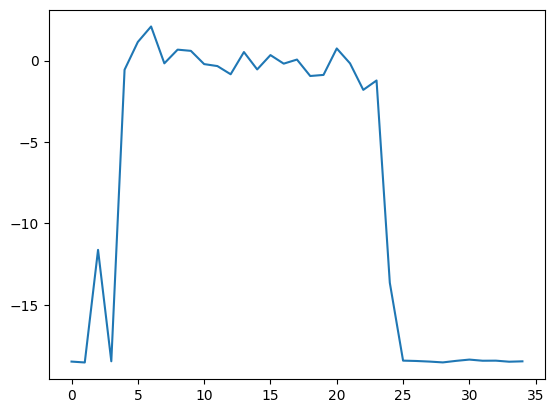

In [39]:
plt.plot(logits[0,:,0].detach().numpy())

In [43]:
torch.sum(logits > -3)

tensor(20)

In [258]:
for i in range(1, L+1):
    logits, _ = model.decoder(
        sampled_tokens[:, :i], 
        encoder_out,
        incremental_state=incremental_state,
    )
    print(logits[0,24,0])
    logits = logits[0].transpose(0, 1)
    probs = F.softmax(logits, dim=-1)
    if sampled_tokens[0, i] == mask_idx:
        sampled_tokens[:, i] = torch.multinomial(probs, 1).squeeze(-1)
sampled_seq = sampled_tokens[0, 1:]

tensor(-13.6373, grad_fn=<SelectBackward0>)
tensor(-16.1490, grad_fn=<SelectBackward0>)
tensor(-16.3561, grad_fn=<SelectBackward0>)
tensor(-19.3800, grad_fn=<SelectBackward0>)
tensor(-17.3698, grad_fn=<SelectBackward0>)
tensor(-16.8180, grad_fn=<SelectBackward0>)
tensor(-14.2246, grad_fn=<SelectBackward0>)
tensor(-18.2690, grad_fn=<SelectBackward0>)
tensor(-18.9166, grad_fn=<SelectBackward0>)
tensor(-20.2359, grad_fn=<SelectBackward0>)
tensor(-22.0253, grad_fn=<SelectBackward0>)
tensor(-23.0814, grad_fn=<SelectBackward0>)
tensor(-25.7956, grad_fn=<SelectBackward0>)
tensor(-17.6135, grad_fn=<SelectBackward0>)
tensor(-20.3028, grad_fn=<SelectBackward0>)
tensor(-17.9384, grad_fn=<SelectBackward0>)
tensor(-24.6782, grad_fn=<SelectBackward0>)
tensor(-20.7243, grad_fn=<SelectBackward0>)
tensor(-23.5556, grad_fn=<SelectBackward0>)
tensor(-15.9172, grad_fn=<SelectBackward0>)
tensor(-23.8805, grad_fn=<SelectBackward0>)
tensor(-19.5721, grad_fn=<SelectBackward0>)
tensor(-14.6606, grad_fn=<Select

In [226]:
sampled_seq

tensor([15, 14,  9,  7, 14, 15,  6, 22,  4, 14,  7,  9,  5,  4,  8,  6,  4, 20,
        18, 19, 18, 13,  5, 10,  9, 17,  7,  4, 11,  4, 15, 13, 14, 10, 13,  9])

In [232]:
model.decoder.dictionary.get_tok(20)

'M'

In [234]:
alphabet_esm.to_dict()

{'<null_0>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32,
 '<cath>': 33,
 '<af2>': 34}

### We need to make sure that the dictionaries of the two samples are the same, otherwise we could be lead to misleading conclusion just based on that

In [122]:
alphabet_aux = alphabet_esm.to_dict()
alphabet_aux_inv = dict(map(reversed, alphabet_aux.items()))

In [123]:
alphabet_aux_inv

{0: '<null_0>',
 1: '<pad>',
 2: '<eos>',
 3: '<unk>',
 4: 'L',
 5: 'A',
 6: 'G',
 7: 'V',
 8: 'S',
 9: 'E',
 10: 'R',
 11: 'T',
 12: 'I',
 13: 'D',
 14: 'P',
 15: 'K',
 16: 'Q',
 17: 'N',
 18: 'F',
 19: 'Y',
 20: 'M',
 21: 'H',
 22: 'W',
 23: 'C',
 24: 'X',
 25: 'B',
 26: 'U',
 27: 'Z',
 28: 'O',
 29: '.',
 30: '-',
 31: '<null_1>',
 32: '<mask>',
 33: '<cath>',
 34: '<af2>'}

In [129]:
samples_esm_transl = []
M_esm = samples_esm.shape[0]
for i in range(M_esm):
    seq = samples_esm[i, ::]
    seq_transl = []
    for num in seq:
        char_esm = alphabet_aux_inv[num.item()]
        num_aa = aa_index[char_esm]
        seq_transl.append(num_aa)
    samples_esm_transl.append(seq_transl)

In [131]:
samples_esm_transl = torch.tensor(samples_esm_transl)

In [135]:
samples_esm_transl

tensor([[16, 15, 20,  ..., 12,  3, 20],
        [16, 12,  7,  ..., 12, 15,  7],
        [ 0, 12, 13,  ..., 12, 20, 12],
        ...,
        [20, 20,  3,  ..., 20, 20,  3],
        [20, 11, 20,  ..., 12, 11, 16],
        [ 0, 14,  0,  ..., 12, 13,  9]])

In [185]:
#model.decoder.dictionary.to_dict()  ##this is the same as the alphabet_esm object

### SEEMS HE DOES NOT SAMPLE FROM IT'S OWN DICTIONARY...

In [134]:
samples_esm

tensor([[11,  8,  2,  ..., 14,  9,  3],
        [11, 14, 12,  ..., 14,  8, 12],
        [ 5, 14, 16,  ..., 14,  0, 14],
        ...,
        [ 2,  3,  9,  ...,  0,  3,  9],
        [ 0, 17,  0,  ..., 14, 17, 11],
        [ 5, 10,  5,  ..., 14, 16,  4]])

In [181]:
proj_esm = pca_mse.transform(samples_esm)

In [41]:
############### UNCOMMENT IF WE GET SAMPLES OF DIFFERENT LENGTH ########################
#lens = [len(sample) for sample in samples_esm]
#samples_esm_ref = [sample for sample in samples_esm if len(sample)==N]
#samples_esm = torch.tensor(samples_esm)
#proj_esm = pca_mse.transform(samples_esm)

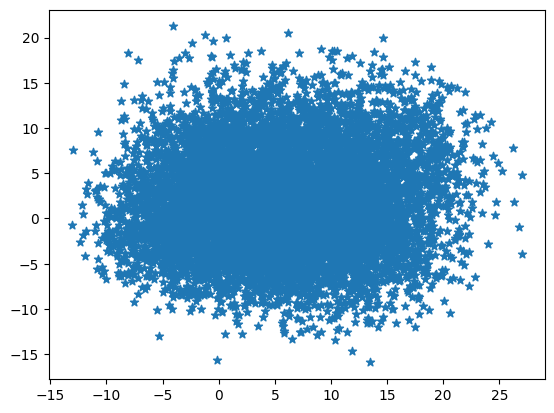

In [180]:
plt.scatter(proj_esm[:, 0], proj_esm[:, 1], marker="*")

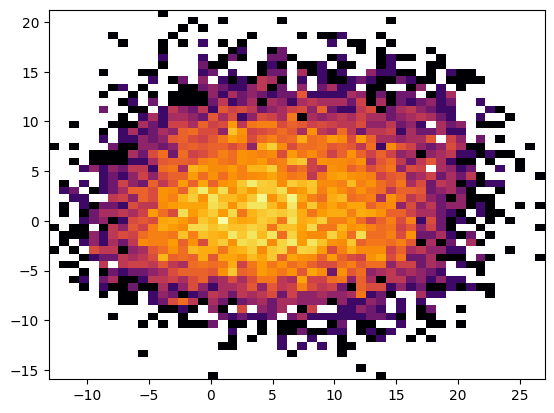

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=1)

#heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

#plt.clf()
#plt.imshow(heatmap.T, extent=extent, origin='lower', cmap="inferno")

ax.hist2d(proj_esm[:,0], proj_esm[:,1], bins=50, norm=colors.LogNorm(), cmap="inferno")
plt.show()

In [140]:
samples_esm_transl

tensor([[16, 15, 20,  ..., 12,  3, 20],
        [16, 12,  7,  ..., 12, 15,  7],
        [ 0, 12, 13,  ..., 12, 20, 12],
        ...,
        [20, 20,  3,  ..., 20, 20,  3],
        [20, 11, 20,  ..., 12, 11, 16],
        [ 0, 14,  0,  ..., 12, 13,  9]])

In [22]:
native_seq

'DVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKA'

In [16]:
native_seq_num = []
for char in native_seq:
    native_seq_num.append(aa_index[char])

In [17]:
samples_esm=torch.tensor(samples_esm)

/tmp/ipykernel_28639/1648735316.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples_esm=torch.tensor(samples_esm)


In [18]:
scores = (samples_esm == torch.tensor(native_seq_num).unsqueeze(0))

In [19]:
hamming_scores = torch.sum(scores, dim=-1)/samples_esm.shape[1]

(array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        10.0000006,  0.       ,  0.       ,  0.       ,  0.       ]),
 array([-0.1111111 , -0.0111111 ,  0.0888889 ,  0.18888889,  0.2888889 ,
         0.3888889 ,  0.48888889,  0.58888888,  0.68888891,  0.78888887,
         0.8888889 ]),
 <BarContainer object of 10 artists>)

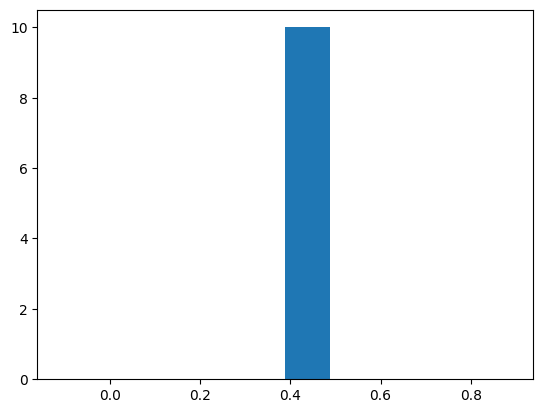

In [20]:
plt.hist(hamming_scores, density=True)

In [146]:
scores_true = (msa_true == torch.tensor(native_seq_num).unsqueeze(0))
hamming_scores_true = torch.sum(scores_true, dim=-1)/N


(array([1337., 3108., 3899., 3737., 1239.,  627.,  260.,  147.,   42.,
          88.]),
 array([0.11111111, 0.2       , 0.2888889 , 0.37777779, 0.46666667,
        0.55555558, 0.64444447, 0.73333335, 0.82222223, 0.91111112,
        1.        ]),
 <BarContainer object of 10 artists>)

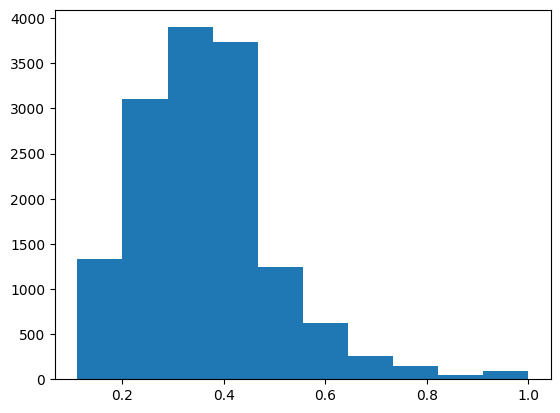

In [147]:
plt.hist(hamming_scores_true)

In [71]:
def get_embedding(q):

    embedding = torch.nn.Embedding(q+1, q).requires_grad_(False)
    embedding.weight.data.zero_()

    embedding.weight[:q, :q] = torch.eye(q)

    return embedding
embeddings = get_embedding(q)

In [154]:
samples_esm_emb = embeddings(samples_esm_transl)

In [155]:
samples_esm_emb.shape

torch.Size([10000, 36, 21])

In [161]:
fi_esm = torch.sum(samples_esm_emb, dim=0)/M_esm

In [162]:
M,N = msa_true.shape 
msa_true_emb = embeddings(msa_true)
fi_true=torch.sum(msa_true_emb, dim=0)/M

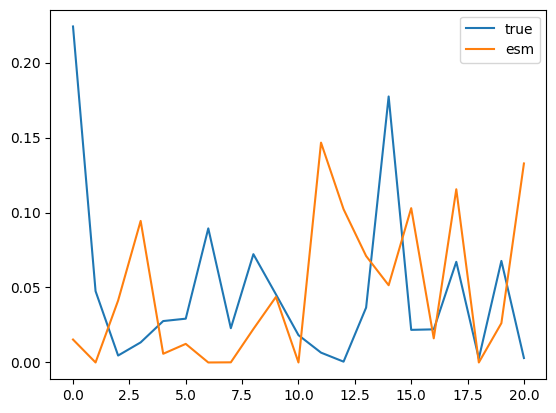

In [164]:
fig,ax=plt.subplots(nrows=1, ncols=1)
ax.plot(fi_true[10,:], label="true")
ax.plot(fi_esm[10,:], label="esm")
ax.legend()

In [340]:
torch.max(fi_esm)

tensor(1.)

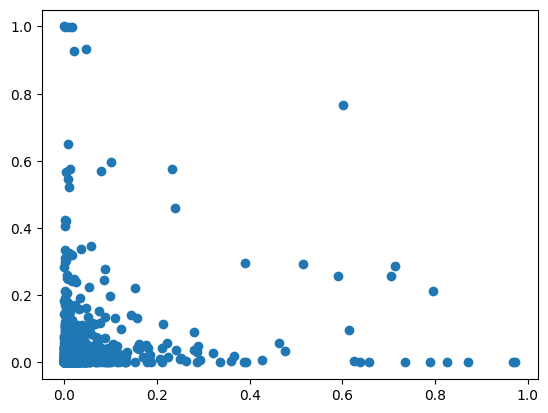

In [341]:
plt.scatter(fi_true.flatten(), fi_esm.flatten())

In [105]:
M_p, N = msa_t.shape
msa_t_emb = embeddings(msa_t)
fi_potts = torch.sum(msa_t_emb, dim=0)/M_p

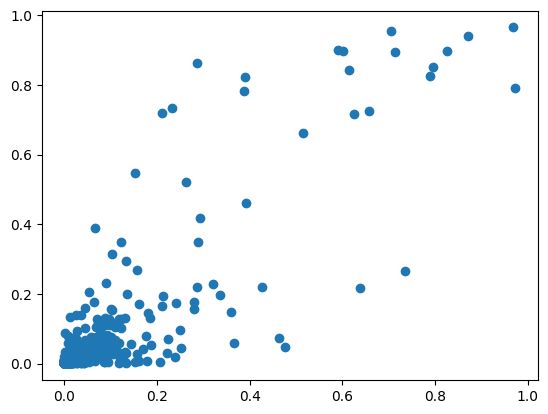

In [107]:
plt.scatter(fi_true.flatten(), fi_potts.flatten())

### Test asked by Barth: distribution of distances between generated samples and between generated sample and true samples.

In [ ]:
samples_esm = []
samples_str = []
for attempt in range(1000):
    print(f"We are at sample {attempt} out of {1000}", end="\r")
    sample = model.sample(coords, temperature=1.0)
    samples_str.append(sample)
    seq_num = []
    for char in sample:
        seq_num.append(aa_index[char])
    samples_esm.append(seq_num)

In [275]:
native_seq_num = []
for char in native_seq:
    native_seq_num.append(aa_index[char])


In [274]:
def get_embedding(q):

    embedding = torch.nn.Embedding(q+1, q).requires_grad_(False)
    embedding.weight.data.zero_()

    embedding.weight[:q, :q] = torch.eye(q)

    return embedding
embeddings = get_embedding(q)

In [277]:
samples_esm = torch.tensor(samples_esm)
samples_esm_emb = embeddings(samples_esm)

In [311]:
distances = []
M_esm = 1000
for i in range(M_esm):
    for j in range(i+1, M_esm):
        distances.append(torch.sum(samples_esm[i,:] == samples_esm[j,:]).item()/N)


(array([4.94894895e-02, 6.77237237e-01, 3.18366366e+00, 5.78666667e+00,
        4.80562849e+00, 2.06040326e+00, 5.03131703e-01, 6.98412698e-02,
        6.52080652e-03, 2.74560275e-04]),
 array([0.11111111, 0.16944444, 0.22777778, 0.28611111, 0.34444444,
        0.40277778, 0.46111111, 0.51944444, 0.57777778, 0.63611111,
        0.69444444]),
 <BarContainer object of 10 artists>)

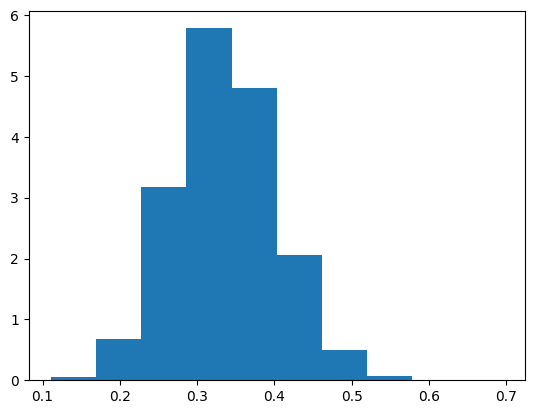

In [318]:
plt.hist(distances, density=True)

In [320]:
distances_true = []
for i in range(M_esm):
    for j in range(M):
        distances_true.append(torch.sum(samples_esm[i,:] == msa_true[j,:]).item()/N)

(array([1.44099420e-02, 3.63070091e-01, 3.67765501e+00, 4.39882320e+00,
        4.72099188e+00, 9.79229826e-01, 2.37598012e-01, 7.78359569e-03,
        4.37448219e-04, 9.94200497e-07]),
 array([0.        , 0.06944444, 0.13888889, 0.20833333, 0.27777778,
        0.34722222, 0.41666667, 0.48611111, 0.55555556, 0.625     ,
        0.69444444]),
 <BarContainer object of 10 artists>)

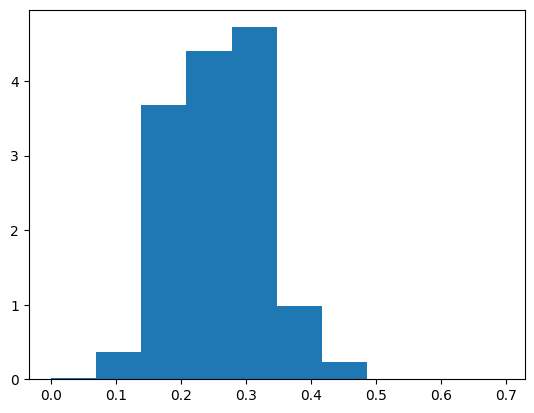

In [321]:
plt.hist(distances_true, density=True)

In [330]:
M_potts = msa_t.shape[0]
distances_potts = []
for i in range(M_potts//10):
    for j in range(i+1, M_potts//10):
        distances_potts.append(torch.sum(msa_t[i,:] == msa_t[j,:]).item()/N)

(array([2.54826255e-03, 4.06949807e-02, 3.40669241e-01, 1.78731017e+00,
        2.60383526e+00, 4.91606178e+00, 2.68453024e+00, 4.59305019e-01,
        2.19047619e-02, 2.83140283e-04]),
 array([0.05555556, 0.13333333, 0.21111111, 0.28888889, 0.36666667,
        0.44444444, 0.52222222, 0.6       , 0.67777778, 0.75555556,
        0.83333333]),
 <BarContainer object of 10 artists>)

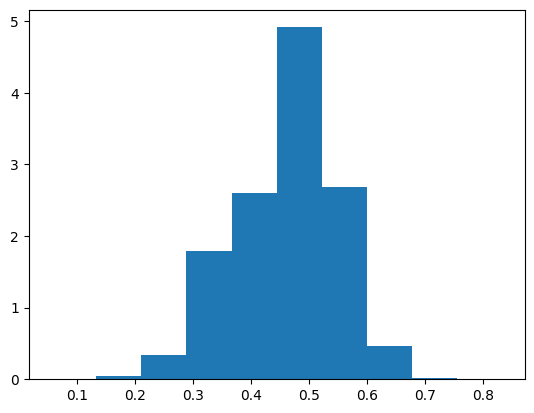

In [331]:
plt.hist(distances_potts, density=True)

In [334]:
M_potts = msa_t.shape[0]
distances_potts_true = []
for i in range(M_potts//10):
    for j in range(M//10):
        distances_potts_true.append(torch.sum(msa_t[i,:] == msa_true[j,:]).item()/N)

(array([5.95728857e-03, 8.78676158e-02, 4.06319592e-01, 2.72427858e+00,
        3.45107735e+00, 4.67037080e+00, 2.07901721e+00, 3.54176583e-01,
        6.53389290e-02, 1.74989375e-03]),
 array([0.02777778, 0.1       , 0.17222222, 0.24444444, 0.31666667,
        0.38888889, 0.46111111, 0.53333333, 0.60555556, 0.67777778,
        0.75      ]),
 <BarContainer object of 10 artists>)

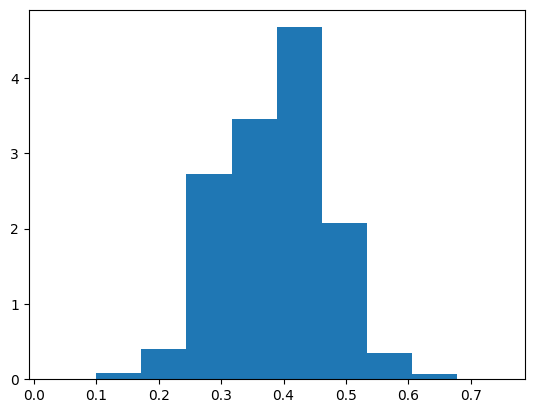

In [335]:
plt.hist(distances_potts_true, density=True)

In [332]:
M//10

1448

In [348]:
samples_esm[1:5, 1:10]

tensor([[ 0, 17,  3, 12,  2,  5, 18,  3,  0],
        [ 3,  0, 10, 12,  3,  5, 19, 17, 13],
        [12, 14,  9, 12, 15,  5, 18,  7, 13],
        [ 3,  9,  9, 12,  2,  5, 19, 17,  0]])

In [347]:
native_seq_num[1:10]

[17, 12, 9, 12, 0, 5, 18, 3, 10]